<a href="https://colab.research.google.com/github/Kasaligan/Machine-Learning-UNS/blob/main/Clase_3_Ejercicio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importo el dataset con las canciones.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


atributos = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv")
atributos.describe()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,1008.000000,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,582.402066,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000000,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,504.000000,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,1008.000000,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,1512.000000,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,2016.000000,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


Veo las etiquetas del dataset para corroborar orden y datos de cada etiqueta.

In [ ]:
print(atributos)
print(atributos.columns)


      Unnamed: 0  ...            artist
0              0  ...            Future
1              1  ...  Childish Gambino
2              2  ...            Future
3              3  ...       Beach House
4              4  ...       Junior Boys
...          ...  ...               ...
2012        2012  ...    Kill The Noise
2013        2013  ...    Dillon Francis
2014        2014  ...          Rain Man
2015        2015  ...        Twin Moons
2016        2016  ...         Bleachers

[2017 rows x 17 columns]
Index(['Unnamed: 0', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'target',
       'song_title', 'artist'],
      dtype='object')


En base a la informacion vista hasta ahora observo que:
1.   La primera columna es un indice y puede ser eliminada. Este indice ya lo tenemos incorporado en el propio dataframe.
2.   Puede ser conveniente separar el dataset en tres partes: 
  * parametros cuantitativos
  * parametros cualitativos (nombre de cancion, artista)
  * target

Llamaremos a estos sub-datasets: "param_n" , "param_c" y "target".

Como no se si algun ordenamiento en el dataset, y luego tendre que separar estas divisiones en train y test para el diseño y comprobacion del predictor, primero mezclo las filas del dataset de atributos.

In [ ]:
atributos_rand=atributos.sample(frac=1)   #mezclo filas del datast

param_n=atributos_rand.drop(['Unnamed: 0','song_title','artist','target'] , axis=1)     #elimino las columnas indicadas
param_c=atributos_rand.drop(atributos.columns.difference(['song_title','artist']) , axis=1)    #elimino las columnas *distintas* a las indicadas
target=atributos_rand.drop(atributos.columns.difference(['target']) , axis=1)

#Muestro las etiquetas de las columnas para confirmar
print('Columnas de param_n:\n' , param_n.columns,'\n')
print('Columnas de param_c:\n' ,param_c.columns,'\n')
print('Columnas de target:\n' ,target.columns,'\n')
print(atributos_rand)

Columnas de param_n:
 Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence'],
      dtype='object') 

Columnas de param_c:
 Index(['song_title', 'artist'], dtype='object') 

Columnas de target:
 Index(['target'], dtype='object') 

      Unnamed: 0  ...              artist
545          545  ...              Miguel
321          321  ...         Goody Goody
276          276  ...               Ekkah
983          983  ...           LION BABE
1597        1597  ...  Wilhelm Stenhammar
...          ...  ...                 ...
915          915  ...           New Order
1451        1451  ...        Mickey Valen
1188        1188  ...             Pitbull
1941        1941  ...     Billy Ray Cyrus
1909        1909  ...         Spice Girls

[2017 rows x 17 columns]


A continuacion creo histogramas para visualizar la forma de los parametros numericos (solo porque es un dataset relativamente chico, no podria hacerlo si tuviera datasets mas grandes) y comparar con los resulados del analisis estadistico hecho en la primer seccion. Lo que busco es indentificar si hay distribuciones que puedan considerarse gaussianas, o si hay etiquetas con distribuciones "extrañas".

<Figure size 432x288 with 0 Axes>

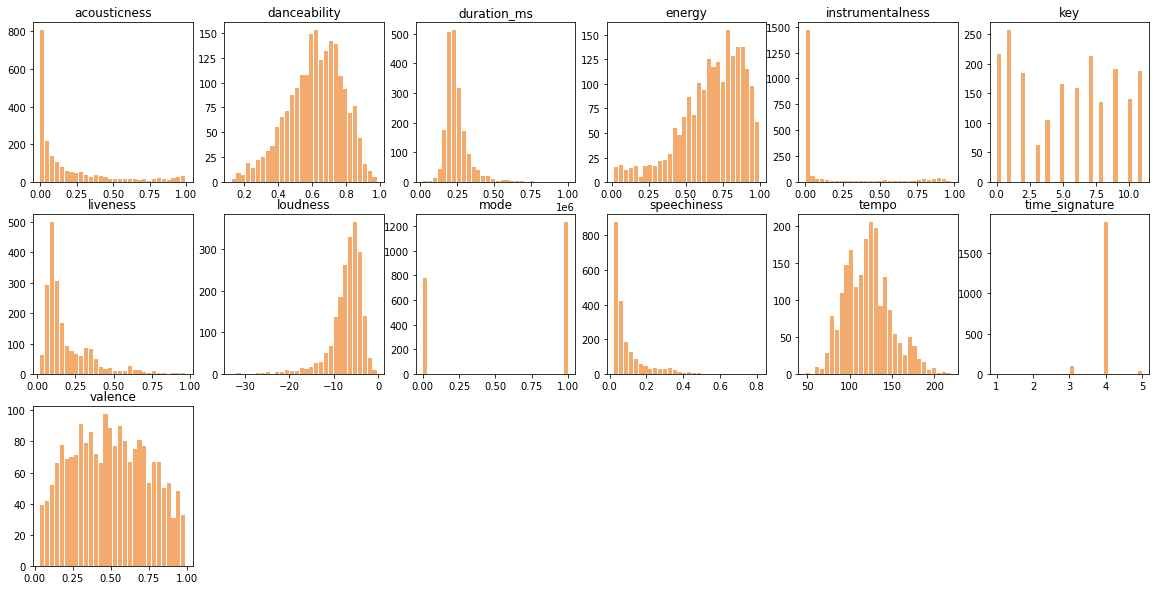

In [ ]:
rango_param_n=len(param_n.columns)     #El numero de columnas o parametros del sub-dataset
intervalos=30     #El numero de intervalos en el histograma

Tot = rango_param_n             #number_of_subplots
Cols = rango_param_n//2         #number_of_columns

# Compute Rows required

Rows = Tot // Cols 
Rows += Tot % Cols

plt.figure()
plt.figure(figsize=(20,10))
for i in range(rango_param_n):
  
  v=i+1               #esto va aca pues i inicia en cero y el primer subplot es de indice 1
  plt.subplot(Rows,Cols,v)
  plt.hist(param_n.iloc[:,i], bins=intervalos, color='#F2AB6D', rwidth=0.85)
  plt.title(param_n.columns[i])

Viendo los histogramas puedo hacer una relacion mas con los parametros estadisticos, y distiguir algunas cosas mas.

**DATOS ELIMINADOS**
1. Vemos que la columna "time_signature" tiene solo 3 valores posibles, y esta demasiado concentrada en uno de ellos, por lo que es poco probable que nos brinde buena informacion para el clasificador. 
2. La columna "mode" esta muy polarizada, y solo con dos valores posibles. Busque informacion sobre que es el "modo" en la musica y nada de lo que pude encontrar daria mediciones siquiera parecidas a lo que tenemos. Descartamos este dato pues no parece ser algo de la musica.
3. "instumentalness" es nuevamente una distribucion muy concentrada. Es poco probable que nos brinde informacion relevante para el clasificador pues la gran mayoria de las canciones tendran valores pequeños.

**DATOS CON POSIBLE INFORMACION **

1. "speechiness" y "acousticness" son dos etiquetas que, si bien presentan cierta concentracion en su distribucion, estan mas dispersas que las etiquetas que seleccionamos para eliminar. Seria interesante ver como se alteran los resultados del predictor al eliminar estos parametros.

En base a lo expuesto hasta ahora, diseñare cuatro predictores basados en KNN.
Los predictores A,B y C no incluiran datos sobre el nombre de la cancion o del artista. El nombre de la cancion se omite pues existe una gran variedad de nombres de canciones, e incluso por experiencia puedo decir que cancioes de nombres "similares" pueden pertenecer a generos muy distintos. Ademas, deberia implementarse un procesador de texto que interprete las ideas de los nombres de las canciones y blah blah blah la cosa es que es demasiado quilombo jaja.
El nombre del artista por otro lado puede dejarse de lado. En principio el objetivo es recomendar musica nueva para el usuario, y si existe una preferencia por un artista en particular es probable que el mismo usuario busque las canciones de dicho artista. 


**PREDICTOR A:**: Se eliminan las etiquetas de **datos eliminados** y las de **datos con posible informacion**.

**PREDICTOR B:** Se eliminan las etiquetas de **datos eliminados**.

**PREDICTOR C:** Se incluyen todas las etiquetas numericas.

**PREDICTOR D, situacional:** Solo si veo que el predictor tiene lugar para mejora, hare un ultimo predictor que tome en cuenta el nombre del artista. 

Preparo los datasets base para cada predictor eliminando las columnas que correspondan. Los datasets propios se definen dentro de cada predictor eliminando las columnas correspondientes.

In [ ]:
param_n_train=param_n.iloc[0:(len(param_n)//2)]
param_n_test=param_n.iloc[(len(param_n)//2)+1:]

#Todos los datasets comparten el target train y test, y los parametros de artista y nombre de cancion
target_train=target.iloc[0:(len(param_n)//2)]
target_test=target.iloc[(len(param_n)//2)+1:]

param_c_train=param_c.iloc[0:(len(param_n)//2)]
param_c_test=param_c.iloc[(len(param_n)//2)+1:]

Los siguientes predictores (A, B y C) comparten el mismo codigo. El codigo solo cambia con el predictor D (pero solo el pre-procesamiento de los datos para el KNN, luego la implementacion del KNN y evaluacion de exactitud, precision y f-measure son similares).

A continuacion se elige la cantidad de vecinos que evaluaran los modelos.

In [ ]:
n_neig=31

# **PREDICTOR A**

In [ ]:
#Dataset para el predictor A
param_n_A_train=param_n_train.drop(['time_signature','mode','instrumentalness','speechiness','acousticness'],axis=1)
param_n_A_test=param_n_test.drop(['time_signature','mode','instrumentalness','speechiness','acousticness'],axis=1)

#Entreno el modelo KNN
KNN_A = KNeighborsClassifier(n_neighbors=n_neig,algorithm="kd_tree")
KNN_A.fit(param_n_A_train,target_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')

Para la comprobacion podria calcular exactitud, precision y f-measure. Puesto que solo tengo dos posibles clasificaciones (target=1 o target=0) puedo reutilizar el codigo que prepare para "Clase 3 - Ejercicio 1", adaptandolo adecuadamente.

In [ ]:
TP=0
TN=0
FP=0
FN=0

#Evaluo el clasificador binario respecto a "1" (caso positivo).

#Como los elementos de prediccion y testeo tienen formato "serie" 
#y esto es ambiguo a nivel booleano, convierto en cada invocacion el parametro a 
#tipo int cada vez que lo invoco dentro de un "if"
#No es la solucion mas elegante, pero no encontre una mejor buscando. 
#Acepto sugerencias

for i in range(len(param_n_A_test)):
  if (int(KNN_A.predict([param_n_A_test.iloc[i]]))==int(target_test.iloc[i])==1):    #Comparo la etiqueta predicha con la real y en base a eso asigno los parametros
    TP=TP+1
  elif (int(KNN_A.predict([param_n_A_test.iloc[i]]))==int(target_test.iloc[i])==0):
    TN=TN+1
  elif (int(KNN_A.predict([param_n_A_test.iloc[i]]))!=int(target_test.iloc[i])==1):
    FN=FN+1
  elif (int(KNN_A.predict([param_n_A_test.iloc[i]]))!=int(target_test.iloc[i])==0):
    FP=FP+1

#Calculo los parametros estadisticos
exact_A = (TP+TN)/(TP+TN+FP+FN)
prec_A =  TP/(TP+FP)
f_m_A = TP/(TP+0.5*(FP+FN))
print("Exactitud: ",exact_A,"\nPrecision: ",prec_A,"\nF-measure: ",f_m_A)

Exactitud:  0.5962301587301587 
Precision:  0.5790441176470589 
F-measure:  0.6075216972034716


# **PREDICTOR B**

In [ ]:
#Dataset para el predictor B
param_n_B_train=param_n_train.drop(['time_signature','mode','instrumentalness'],axis=1)
param_n_B_test=param_n_test.drop(['time_signature','mode','instrumentalness'],axis=1)

#Entreno el modelo KNN
KNN_B = KNeighborsClassifier(n_neighbors=n_neig,algorithm="kd_tree")
KNN_B.fit(param_n_B_train,target_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')

Para la comprobacion podria calcular exactitud, precision y f-measure. Puesto que solo tengo dos posibles clasificaciones (target=1 o target=0) puedo reutilizar el codigo que prepare para "Clase 3 - Ejercicio 1", adaptandolo adecuadamente.

In [ ]:
TP=0
TN=0
FP=0
FN=0

#Evaluo el clasificador binario respecto a "1" (caso positivo).

#Como los elementos de prediccion y testeo tienen formato "serie" 
#y esto es ambiguo a nivel booleano, convierto en cada invocacion el parametro a 
#tipo int cada vez que lo invoco dentro de un "if"
#No es la solucion mas elegante, pero no encontre una mejor buscando. 
#Acepto sugerencias

for i in range(len(param_n_B_test)):
  if (int(KNN_B.predict([param_n_B_test.iloc[i]]))==int(target_test.iloc[i])==1):    #Comparo la etiqueta predicha con la real y en base a eso asigno los parametros
    TP=TP+1
  elif (int(KNN_B.predict([param_n_B_test.iloc[i]]))==int(target_test.iloc[i])==0):
    TN=TN+1
  elif (int(KNN_B.predict([param_n_B_test.iloc[i]]))!=int(target_test.iloc[i])==1):
    FN=FN+1
  elif (int(KNN_B.predict([param_n_B_test.iloc[i]]))!=int(target_test.iloc[i])==0):
    FP=FP+1

#Calculo los parametros estadisticos
exact_B = (TP+TN)/(TP+TN+FP+FN)
prec_B =  TP/(TP+FP)
f_m_B = TP/(TP+0.5*(FP+FN))
print("Exactitud: ",exact_B,"\nPrecision: ",prec_B,"\nF-measure: ",f_m_B)

Exactitud:  0.5962301587301587 
Precision:  0.5790441176470589 
F-measure:  0.6075216972034716


# **PREDICTOR C**

In [ ]:
#Dataset para el predictor A
param_n_C_train=param_n_train
param_n_C_test=param_n_test

#Entreno el modelo KNN
KNN_C = KNeighborsClassifier(n_neighbors=n_neig,algorithm="kd_tree")
KNN_C.fit(param_n_C_train,target_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')

Para la comprobacion podria calcular exactitud, precision y f-measure. Puesto que solo tengo dos posibles clasificaciones (target=1 o target=0) puedo reutilizar el codigo que prepare para "Clase 3 - Ejercicio 1", adaptandolo adecuadamente.

In [ ]:
TP=0
TN=0
FP=0
FN=0

#Evaluo el clasificador binario respecto a "1" (caso positivo).

#Como los elementos de prediccion y testeo tienen formato "serie" 
#y esto es ambiguo a nivel booleano, convierto en cada invocacion el parametro a 
#tipo int cada vez que lo invoco dentro de un "if"
#No es la solucion mas elegante, pero no encontre una mejor buscando. 
#Acepto sugerencias

for i in range(len(param_n_C_test)):
  if (int(KNN_C.predict([param_n_C_test.iloc[i]]))==int(target_test.iloc[i])==1):    #Comparo la etiqueta predicha con la real y en base a eso asigno los parametros
    TP=TP+1
  elif (int(KNN_C.predict([param_n_C_test.iloc[i]]))==int(target_test.iloc[i])==0):
    TN=TN+1
  elif (int(KNN_C.predict([param_n_C_test.iloc[i]]))!=int(target_test.iloc[i])==1):
    FN=FN+1
  elif (int(KNN_C.predict([param_n_C_test.iloc[i]]))!=int(target_test.iloc[i])==0):
    FP=FP+1

#print(TP)
#print(TN)
#print(FP)
#print(FN)

#Calculo los parametros estadisticos
exact_C = (TP+TN)/(TP+TN+FP+FN)
prec_C =  TP/(TP+FP)
f_m_C = TP/(TP+0.5*(FP+FN))
print("Exactitud: ",exact_C,"\nPrecision: ",prec_C,"\nF-measure: ",f_m_C)

Exactitud:  0.5962301587301587 
Precision:  0.5790441176470589 
F-measure:  0.6075216972034716


##**PREDICTOR D**

Ya que no conseguimos una buena performance en ningun clasificador cuando despreciamos el artista pasamos a la implementacion del ultimo predictor. Este tiene todos los parametros. 

Como KNN solo funciona con valores numericos primero debo convertir de alguna forma los nombres de los artistas en numeros. Para esto primero recupero un dataset que contenga la columna de artistas. Analizo este dataset para recuperar una lista con cada nombre unico que aparece. Luego asigno a los elementos de esta lista un valor numerico. Una vez hecho esto modifico el dataset de canciones para que figure para cada cancion el numero de artista asignado. Esta columna sera la que permitira analizar los artistas con KNN.

In [ ]:
#Preparo los datasets

param_n_D_train=param_n_train
param_n_D_test=param_n_test

#Recordemos que 'param_c' ya contiene solo artista y nombre de cancion
param_c_D_train=param_c_train.loc[:,'artist']   #recupero solo la columna de artistas
param_c_D_test=param_c_test.loc[:,'artist']   #recupero solo la columna de artistas


In [ ]:
#Preparo el indice numerico de artistas 

lista_de_artistas=set(param_c.loc[:,'artist'])    #creo la lista de artistas unicos, usando como base la lista completa 
artistas=pd.DataFrame(data=lista_de_artistas,columns=['artista'])     #paso la lista a un dataframe

d2=np.array(range(0,len(artistas)))   #creo un indice numerico para los artistas
artistas_num=pd.DataFrame(data=d2,columns=['num'])  #creo un dataframe con los indices

artistas=pd.concat([artistas,artistas_num],axis=1)  #uno los dos dataframes
print(artistas)

                                  artista   num
0                         David Hazeltine     0
1                             Seven Lions     1
2                                 Problem     2
3                             Erkin Koray     3
4                            Devin Dawson     4
...                                   ...   ...
1338  Carte Blanche (feat. Alexis Taylor)  1338
1339                         Travis Hayes  1339
1340                           The Afters  1340
1341                            Kari Jobe  1341
1342                       Counting Crows  1342

[1343 rows x 2 columns]


Preparo un bucle para asignar el valor numerico que corresponde a las canciones de los dataset de entrenamiento y testeo. Esta parte del codigo tarda unos 15-20 seg en ejecutarse.

In [ ]:
#---------------BUCLE PARA EL SET DE ENTRENAMIENTO

#Creo este dataframe vacio para luego anexar a los datos con el indice numerico de cada artista
artist_num_train = pd.DataFrame()

for i in range(len(param_c_D_train)):
  j=0  
  while ( param_c_D_train.iloc[i] != artistas.loc[j,'artista'] ):   #Compara el artista de la cancion con el indice numerico de artistas 
    j=j+1
  
  #Saldra del bucle anterior cuando haya encontrado el indice del artista que corresponda luego puedo asignar
  artist_num_train = artist_num_train.append([artistas.loc[j,'num']])


#---------------BUCLE PARA EL SET DE TESTEO

#Creo este dataframe vacio para luego anexar a los datos con el indice numerico de cada artista
artist_num_test = pd.DataFrame()

for i in range(len(param_c_D_test)):
  j=0  
  while ( param_c_D_test.iloc[i] != artistas.loc[j,'artista'] ):   #Compara el artista de la cancion con el indice numerico de artistas 
    j=j+1
  
  #Saldra del bucle anterior cuando haya encontrado el indice del artista que corresponda luego puedo asignar
  artist_num_test = artist_num_test.append([artistas.loc[j,'num']])   


In [ ]:
print(artist_num_train)

       0
0     36
0   1289
0   1168
0    850
0    375
..   ...
0    760
0    103
0    377
0    477
0   1279

[1008 rows x 1 columns]


Ahora que tengo el indice numerico de artistas, lo anexo a los datos numericos y preparo el clasificador.


In [ ]:
#Para poder ejecutar la concatenacion de datos debo resetear los indices
param_n_D_test.reset_index(drop=True,inplace=True) #Drop=True evita que se añada el indice viejo como columna
param_n_D_train.reset_index(drop=True,inplace=True) #inplace modifica el propio archivo sin necesidad de crear uno nuevo
artist_num_test.reset_index(drop=True,inplace=True)
artist_num_train.reset_index(drop=True,inplace=True)

param_n_D_train=pd.concat([param_n_D_train,artist_num_train],axis=1)  #concateno los datos numericos con los artistas (en formato numerico)
param_n_D_test=pd.concat([param_n_D_test,artist_num_test],axis=1)

#Entreno el modelo KNN
KNN_D = KNeighborsClassifier(n_neighbors=n_neig,algorithm="kd_tree")
KNN_D.fit(param_n_D_train,target_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if sys.path[0] == '':


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=31, p=2,
                     weights='uniform')

Para la comprobacion podria calcular exactitud, precision y f-measure. Puesto que solo tengo dos posibles clasificaciones (target=1 o target=0) puedo reutilizar el codigo que prepare para "Clase 3 - Ejercicio 1", adaptandolo adecuadamente.

In [ ]:
TP=0
TN=0
FP=0
FN=0

#Evaluo el clasificador binario respecto a "1" (caso positivo).

#Como los elementos de prediccion y testeo tienen formato "serie" 
#y esto es ambiguo a nivel booleano, convierto en cada invocacion el parametro a 
#tipo int cada vez que lo invoco dentro de un "if"
#No es la solucion mas elegante, pero no encontre una mejor buscando. 
#Acepto sugerencias

for i in range(len(param_n_D_test)):
  if (int(KNN_D.predict([param_n_D_test.iloc[i]]))==int(target_test.iloc[i])==1):    #Comparo la etiqueta predicha con la real y en base a eso asigno los parametros
    TP=TP+1
  elif (int(KNN_D.predict([param_n_D_test.iloc[i]]))==int(target_test.iloc[i])==0):
    TN=TN+1
  elif (int(KNN_D.predict([param_n_D_test.iloc[i]]))!=int(target_test.iloc[i])==1):
    FN=FN+1
  elif (int(KNN_D.predict([param_n_D_test.iloc[i]]))!=int(target_test.iloc[i])==0):
    FP=FP+1

#print(TP)
#print(TN)
#print(FP)
#print(FN)

#Calculo los parametros estadisticos
exact_D = (TP+TN)/(TP+TN+FP+FN)
prec_D =  TP/(TP+FP)
f_m_D = TP/(TP+0.5*(FP+FN))
print('Exactitud: ',exact_D,'\nPrecision: ',prec_D,'\nF-measure: ',f_m_D)

Exactitud:  0.5992063492063492 
Precision:  0.581651376146789 
F-measure:  0.6107899807321773


##COMPARACION

Presento finalmente los resultados de todos los clasificadores.

In [ ]:
print('\t\tMODELO A\tMODELO B\tMODELO C\tMODELO D\n')
print('Exactitud:\t',round(exact_A,4),'\t\t',round(exact_B,4),'\t\t',round(exact_C,4),'\t\t',round(exact_D,4),'\n');
print('Precision:\t',round(prec_A,4),'\t\t',round(prec_B,4),'\t\t',round(prec_C,4),'\t\t',round(prec_D,4),'\n');
print('F-measure:\t',round(f_m_A,4),'\t\t',round(f_m_B,4),'\t\t',round(f_m_C,4),'\t\t',round(f_m_D,4),'\n');

		MODELO A	MODELO B	MODELO C	MODELO D

Exactitud:	 0.5962 		 0.5962 		 0.5962 		 0.5992 

Precision:	 0.579 		 0.579 		 0.579 		 0.5817 

F-measure:	 0.6075 		 0.6075 		 0.6075 		 0.6108 



##CONCLUSIONES

Tras correr el codigo unas cuantas veces puedo decir lo siguiente:

1. El ordenamiento aleatorio que se le da a la muestra influye en la performance del predictor, pero lo hace de igual medida en todos los modelos.
2. No se ve diferencia notable entre los predictores. En todas las iteraciones obtienen parametros de performance bastante similares. 
3. El numero de vecinos que mejores resultados suele brindar es k=30 aproximadamente, que coincide casi con el criterio de la raiz de elementos del dataset de entrenamiento (sqrt(1000)=31.62). 

En base a estas observaciones concluyo que, de los clasificadores que he diseñado, el A es el mejor puesto que toma la menor cantidad de parametros del sistema y brinda resultados similares al del clasificador D, el cual toma casi todos los parametros incluyendo artista (excluyendo nombre de cancion). Aun asi no estoy satisfecho con el desempeño de ninguno pues en extremadamente raras ocasiones alguno de los parametros de performance supera el 60%. Todos los clasificadores resultan solo ligeramente mas eficaces que hacer un "tiro de moneda".